In [1]:
!pip3 install -q --upgrade --user git+https://github.com/pymc-devs/pymc4.git

# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

/home/ferres/Projects/pymc4/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ferres/Projects/pymc4/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ferres/Projects/pymc4/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ferres/Projects/pymc4/ven

In [2]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal(mu=0., sigma=1, name='mu_alpha')
    sigma_a = yield pm.HalfCauchy(beta=1, name='sigma_alpha')
    mu_b = yield pm.Normal(mu=0., sigma=1, name='mu_beta')
    sigma_b = yield pm.HalfCauchy(beta=1, name='sigma_beta')

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal(mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()),
                        name='alpha')
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal(mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()),
                        name='beta')

    # Model error
    eps = yield pm.HalfCauchy(beta=1, name='eps')

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal(mu=radon_est, sigma=eps, observed=data.log_radon, name='y_like')

### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [3]:
def sample(model, init_num_chains=50, num_samples=500, burn_in=500):
    init_num_chains = 50
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=True)
    for i in range(3):
        step_size_ = []
        for _, x in pm4_trace.items():
            std = tf.math.reduce_std(x, axis=[0, 1])
            step_size_.append(
                std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
        pm4_trace, _ = pm.inference.sampling.sample(
            model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
            step_size=step_size_, xla=True)
        
    num_chains = 5
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

    pm4_trace, sample_stat = pm.inference.sampling.sample(
        model, num_chains=num_chains, num_samples=num_samples, burn_in=burn_in,
        step_size=step_size_, xla=True)
    
    az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)
    
    return az_trace

In [4]:
model = hierarchical_model(data, county_idx)
az_trace = sample(model)

W1008 23:56:53.058055 140164205540992 deprecation.py:323] From /home/ferres/Projects/pymc4/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1404: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.754976, 0.8365  , 0.749697, 0.790316, 0.871318], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

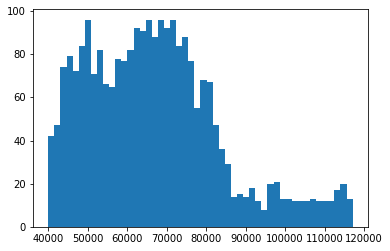

In [6]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [7]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/mu_alpha,1.490,0.050,1.394,1.580,0.001,0.001,1131.0,1131.0,1139.0,1449.0,1.00
hierarchical_model/mu_beta,-0.646,0.082,-0.810,-0.503,0.003,0.002,560.0,560.0,565.0,805.0,1.01
hierarchical_model/alpha[0],1.219,0.252,0.776,1.702,0.007,0.005,1435.0,1431.0,1432.0,1398.0,1.00
hierarchical_model/alpha[1],0.982,0.093,0.826,1.170,0.002,0.001,2373.0,2373.0,2413.0,1357.0,1.00
hierarchical_model/alpha[2],1.509,0.263,1.018,2.027,0.007,0.005,1611.0,1551.0,1610.0,1538.0,1.01
hierarchical_model/alpha[3],1.548,0.222,1.154,1.947,0.005,0.004,1661.0,1661.0,1655.0,1604.0,1.00
hierarchical_model/alpha[4],1.453,0.248,1.008,1.929,0.007,0.005,1378.0,1378.0,1377.0,1346.0,1.00
hierarchical_model/alpha[5],1.506,0.258,0.999,1.973,0.007,0.005,1547.0,1529.0,1548.0,1515.0,1.00
hierarchical_model/alpha[6],1.854,0.170,1.549,2.181,0.003,0.002,2852.0,2798.0,2852.0,1858.0,1.00
hierarchical_model/alpha[7],1.702,0.237,1.267,2.131,0.005,0.004,2273.0,2273.0,2276.0,1755.0,1.00


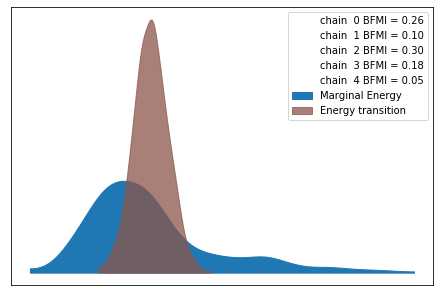

In [8]:
az.plot_energy(az_trace);

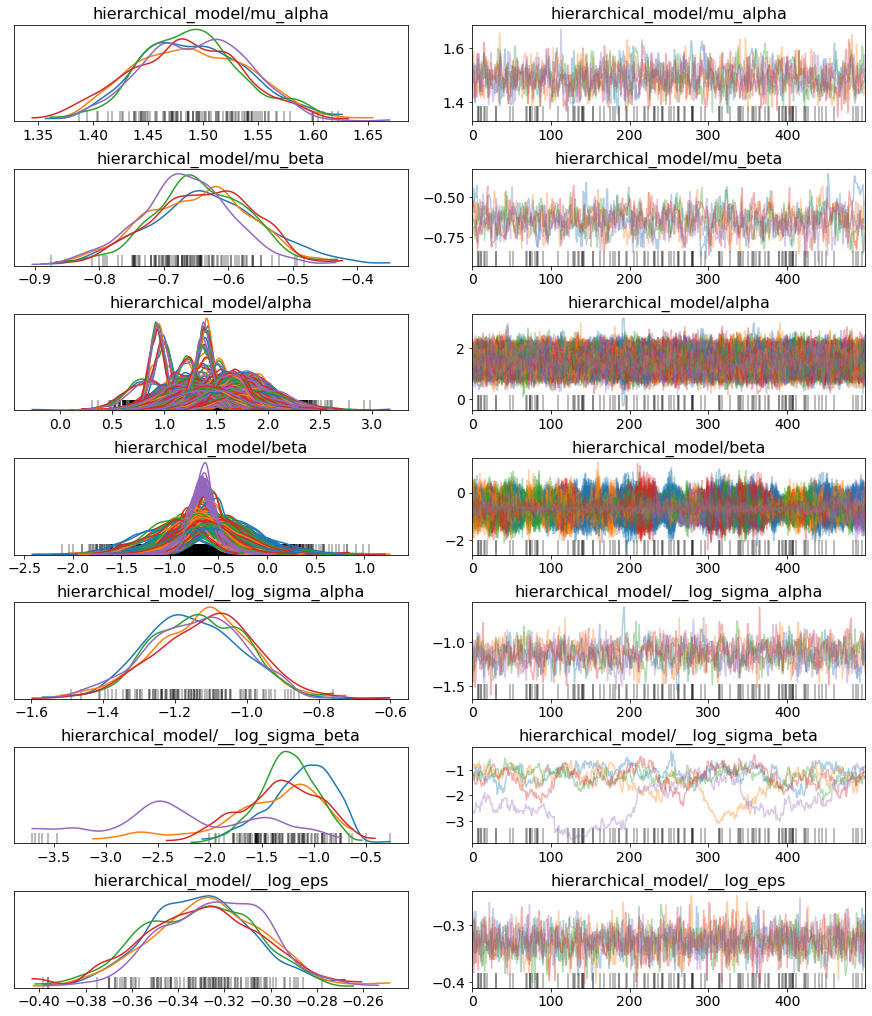

In [9]:
az.plot_trace(az_trace, compact=True);

## Models are just distributions

In [10]:
@pm.model
def Hierarchical(n, centered=True):
    mu = yield pm.Normal(mu=0., sigma=1, name='mu')
    sigma = yield pm.HalfCauchy(beta=1, name='sigma')
    if centered:
        s = yield pm.Normal(mu=mu, sigma=sigma, 
                            plate=n, name='s')
    else:
        offset = yield pm.Normal(mu=0, sigma=1, 
                                 plate=n, name='offset')
        s = mu + sigma * offset
    return s
    
@pm.model
def hierarchical_model_nc(data, county_idx):
    n = len(data.county.unique())
    # TODO Use same name-syntax as with other RVs
    a = yield Hierarchical(n=n, centered=True, name='alpha')
    b = yield Hierarchical(n=n, centered=False, name='beta')

    # Model error
    eps = yield pm.HalfCauchy(beta=1, name='eps')

    # Expected value
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood    
    y_like = yield pm.Normal(mu=radon_est, sigma=eps, observed=data.log_radon, name='y_like')

In [11]:
model = hierarchical_model_nc(data, county_idx)
az_trace_nc = sample(model)

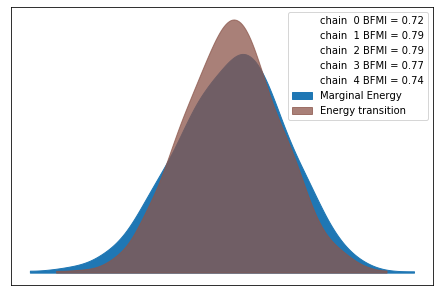

In [12]:
az.plot_energy(az_trace_nc);

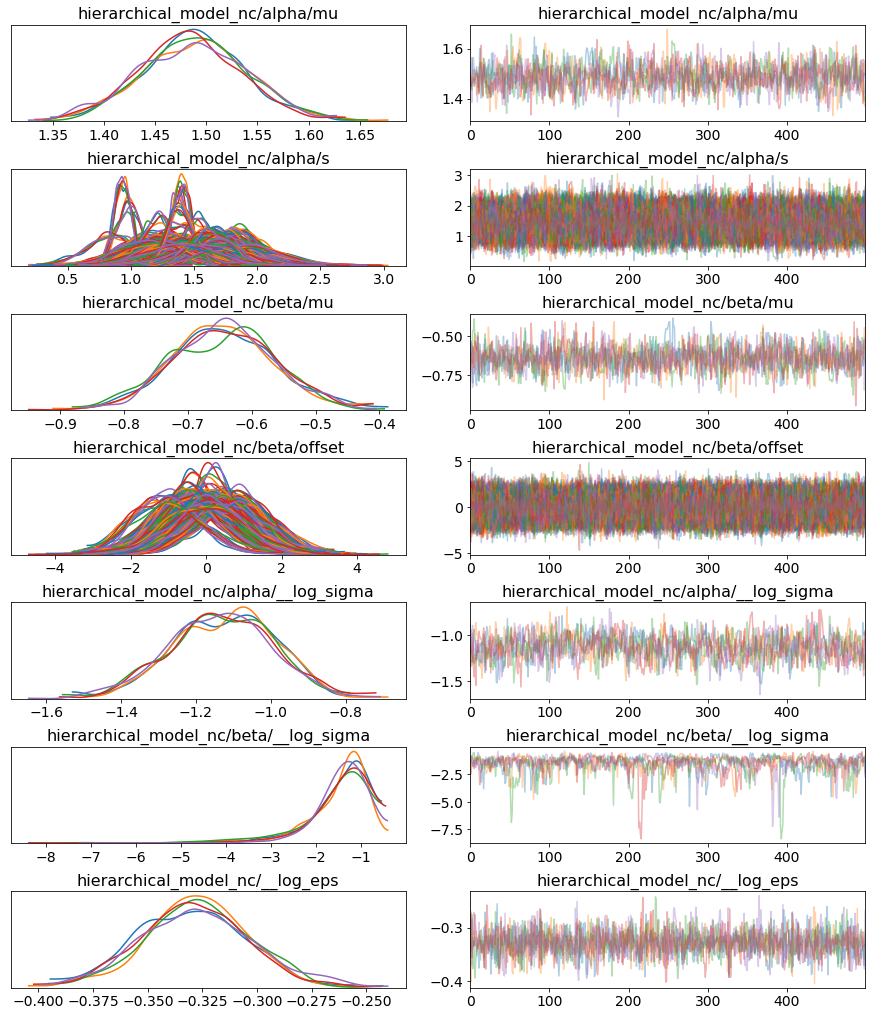

In [13]:
az.plot_trace(az_trace_nc, compact=True);

In [93]:
def sample_posterior_predictive(model, trace, n_samples=100):
    _, state = pm.evaluate_model_transformed(model, values={k: v.data[0, 0] for k, v in trace.posterior.items()})
    observed_names = list(state.observed_values.keys())
    ppc_results = {k: np.empty((n_samples, )+v.shape) for k, v in state.observed_values.items()}
    def loop_fn(chain, draw):
        values = {k: v.data[chain, draw] for k, v in trace.posterior.items()}
        observed = dict.fromkeys(observed_names, None)
        _, state = pm.evaluate_model_transformed(model, values=values, observed=observed)
        return {k: state.all_values[k] for k in observed_names}
    
    for i, (chain, draw) in enumerate(zip(
        np.random.choice(trace.posterior.chain, size=n_samples), np.random.choice(trace.posterior.draw, size=n_samples)
    )):
        sample = loop_fn(chain, draw)
        for k, v in sample.items():
            ppc_results[k][i] = v
    return ppc_results

In [96]:
ppc = sample_posterior_predictive(model, az_trace_nc)

In [97]:
ppc

{'hierarchical_model_nc/y_like': array([[ 0.85626608,  1.36210465,  0.41732478, ...,  1.64159405,
          2.8686924 ,  2.84959626],
        [ 0.21636869,  1.60067236, -0.06077492, ...,  1.11252666,
          1.09459686,  1.80493915],
        [-0.07006544,  0.18710327,  1.31304502, ...,  2.19721651,
          0.77483135,  0.71874589],
        ...,
        [-0.82583588,  0.65155256, -0.66278708, ...,  1.31454122,
          1.73934841,  1.2800597 ],
        [-0.07585514,  0.75298309,  1.29876924, ...,  1.88446498,
          1.7290864 ,  0.88672066],
        [ 0.70626414,  2.36037898,  1.96693718, ...,  0.64664346,
          1.24177229,  3.67030144]])}